In [ ]:
# CATEGORY = "Baby_Products"
CATEGORY = "Video_Games"

# Define sequence lengths
MIN_SEQUENCE_LENGTH = 3
MAX_SEQUENCE_LENGTH = 100  # Adjust as needed

In [ ]:
import sys
from pathlib import Path

NOTEBOOK_DIR = Path.cwd()
PROJECT_ROOT = NOTEBOOK_DIR.parent
sys.path.append(str(PROJECT_ROOT))

# Data directory
DATA_DIR = Path(PROJECT_ROOT, "data")
DATA_DIR.mkdir(exist_ok=True)

In [ ]:
import matplotlib.pyplot as plt
import numpy as np
import polars as pl

from src.logger import setup_logger

logger = setup_logger("dataprep")

## Load and merge data

In [ ]:
# LOAD ORIGINAL METADATA
metadata_output_path = DATA_DIR / "output" / f"{CATEGORY}_items.parquet"
item_df = pl.read_parquet(metadata_output_path)
logger.info(f"Loaded {len(item_df):,} items from {metadata_output_path}")

# LOAD AUGMENTED METADATA\
augmented_metadata_path = DATA_DIR / "output" / f"{CATEGORY}_metadata_extracted.parquet"
augmented_df = pl.read_parquet(augmented_metadata_path)
logger.info(f"Loaded {len(augmented_df):,} augmented metadata records from {augmented_metadata_path}")

# LOAD CLEANED DESCRIPTIONS
cleaned_descriptions_path = DATA_DIR / "output" / f"{CATEGORY}_descriptions_clean.csv"
cleaned_descriptions_df = pl.read_csv(cleaned_descriptions_path)
cleaned_descriptions_df = cleaned_descriptions_df.unique(subset=["parent_asin"])
cleaned_descriptions_df = cleaned_descriptions_df.filter(pl.col("clean_description") != "NA")
logger.info(f"Loaded {len(cleaned_descriptions_df):,} cleaned descriptions from {cleaned_descriptions_path}")

# LOAD CLEANED TITLES
cleaned_titles_path = DATA_DIR / "output" / f"{CATEGORY}_titles_clean.csv"
cleaned_titles_df = pl.read_csv(cleaned_titles_path)
cleaned_titles_df = cleaned_titles_df.unique(subset=["parent_asin"])
cleaned_titles_df = cleaned_titles_df.filter(pl.col("clean_title") != "NA")
logger.info(f"Loaded {len(cleaned_titles_df):,} cleaned titles from {cleaned_titles_path}")

# MERGE DATAFRAMES
item_df = item_df.join(cleaned_descriptions_df, on="parent_asin", how="inner")
item_df = item_df.join(cleaned_titles_df, on="parent_asin", how="inner")
item_df = item_df.join(augmented_df, on="parent_asin", how="left")  # Left join to keep all items
logger.info(f"Merged {len(item_df):,} items with cleaned descriptions, titles, and augmented metadata")

15:32:52 - Loaded 66,133 items from /Users/eugeneyan/projects/semantic-id/data/output/Video_Games_items.parquet
15:32:52 - Loaded 66,097 augmented metadata records from /Users/eugeneyan/projects/semantic-id/data/output/Video_Games_metadata_extracted.parquet
15:32:52 - Loaded 66,099 cleaned descriptions from /Users/eugeneyan/projects/semantic-id/data/output/Video_Games_descriptions_clean.csv
15:32:52 - Loaded 66,131 cleaned titles from /Users/eugeneyan/projects/semantic-id/data/output/Video_Games_titles_clean.csv
15:32:52 - Merged 66,097 items with cleaned descriptions, titles, and augmented metadata


In [ ]:
# Clean up xml tags that remain
item_df = item_df.with_columns(
    pl.col("clean_description")
    .str.replace_all(r"</?[^>]+>", " ")  # Remove all tags
    .str.replace_all(r"\s+", " ")  # Collapse multiple spaces
    .str.strip_chars()  # Trim whitespace
    .alias("clean_description"),
    pl.col("clean_title")
    .str.replace_all(r"</?[^>]+>", " ")  # Remove all tags
    .str.replace_all(r"\s+", " ")  # Collapse multiple spaces
    .str.strip_chars()  # Trim whitespace
    .alias("clean_title"),
)

assert (
    len(
        item_df.filter(pl.col("clean_description").str.contains("clean_description")).select(
            ["description_text", "clean_description"]
        )
    )
    == 0
)
assert len(item_df.filter(pl.col("clean_title").str.contains("clean_title")).select(["title", "clean_title"])) == 0

## Description Length Analysis

In [ ]:
# Calculate character lengths for original and cleaned descriptions
item_df = item_df.with_columns(
    [
        pl.col("description_text").str.len_chars().cast(pl.Int64).alias("original_desc_length"),
        pl.col("clean_description").str.len_chars().cast(pl.Int64).alias("clean_desc_length"),
        pl.col("title").str.len_chars().cast(pl.Int64).alias("original_title_length"),
        pl.col("clean_title").str.len_chars().cast(pl.Int64).alias("clean_title_length"),
    ]
)

item_df = item_df.with_columns(
    [
        (pl.col("original_desc_length") - pl.col("clean_desc_length")).cast(pl.Int64).alias("desc_char_reduction"),
        ((pl.col("original_desc_length") - pl.col("clean_desc_length")) / pl.col("original_desc_length"))
        .cast(pl.Float64)
        .alias("desc_reduction_prop"),
        (pl.col("original_title_length") - pl.col("clean_title_length")).cast(pl.Int64).alias("title_char_reduction"),
        ((pl.col("original_title_length") - pl.col("clean_title_length")) / pl.col("original_title_length"))
        .cast(pl.Float64)
        .alias("title_reduction_prop"),
    ]
)

# Calculate statistics
stats = item_df.select(
    [
        pl.col("original_desc_length").mean().alias("original_desc_mean"),
        pl.col("original_desc_length").median().alias("original_desc_median"),
        pl.col("original_desc_length").std().alias("original_desc_std"),
        pl.col("clean_desc_length").mean().alias("clean_desc_mean"),
        pl.col("clean_desc_length").median().alias("clean_desc_median"),
        pl.col("clean_desc_length").std().alias("clean_desc_std"),
        (pl.col("original_desc_length") - pl.col("clean_desc_length")).mean().alias("avg_desc_reduction"),
        ((pl.col("original_desc_length") - pl.col("clean_desc_length")) / pl.col("original_desc_length") * 100)
        .mean()
        .alias("avg_desc_reduction_pct"),
    ]
)

logger.info("Description Length Statistics:")
logger.info("=" * 50)
for col in stats.columns:
    value = stats[col][0]
    if "pct" in col:
        logger.info(f"{col}: {value:.1f}%")
    else:
        logger.info(f"{col}: {value:.1f}")

# Calculate reduction statistics
total_original_chars = item_df["original_desc_length"].sum()
total_clean_chars = item_df["clean_desc_length"].sum()
total_reduction = total_original_chars - total_clean_chars
total_reduction_pct = (total_reduction / total_original_chars) * 100

logger.info("Total Character Statistics:")
logger.info("=" * 50)
logger.info(f"Total original characters: {total_original_chars:,}")
logger.info(f"Total clean characters: {total_clean_chars:,}")
logger.info(f"Total reduction: {total_reduction:,} ({total_reduction_pct:.1f}%)")

15:32:52 - Description Length Statistics:
15:32:52 - ==================================================
15:32:52 - original_desc_mean: 1038.7
15:32:52 - original_desc_median: 643.0
15:32:52 - original_desc_std: 1456.6
15:32:52 - clean_desc_mean: 583.8
15:32:52 - clean_desc_median: 561.0
15:32:52 - clean_desc_std: 265.6
15:32:52 - avg_desc_reduction: 454.9
15:32:52 - avg_desc_reduction_pct: 12.5%
15:32:52 - Total Character Statistics:
15:32:52 - ==================================================
15:32:52 - Total original characters: 68,654,365
15:32:52 - Total clean characters: 38,588,214
15:32:52 - Total reduction: 30,066,151 (43.8%)


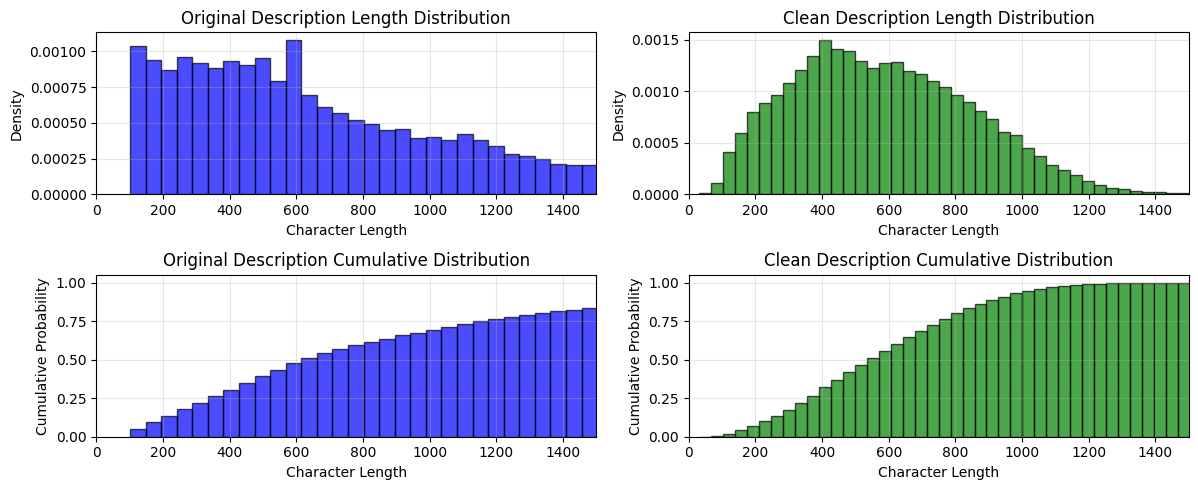

In [ ]:
# Create figure with 2x2 subplots
fig, axes = plt.subplots(2, 2, figsize=(12, 5))
X_AXIS_LIMIT = 1500

# Convert to numpy arrays for plotting
original_lengths = item_df["original_desc_length"].to_numpy()
clean_lengths = item_df["clean_desc_length"].to_numpy()

# 1. Histogram with density for original descriptions
ax1 = axes[0, 0]
n1, bins1, patches1 = ax1.hist(original_lengths, bins=2000, density=True, alpha=0.7, color="blue", edgecolor="black")
ax1.set_xlabel("Character Length")
ax1.set_ylabel("Density")
ax1.set_title("Original Description Length Distribution")
ax1.set_xlim(0, X_AXIS_LIMIT)  # Limit x-axis to 99th percentile for better visibility
ax1.grid(True, alpha=0.3)

# 2. Histogram with density for clean descriptions
ax2 = axes[0, 1]
n2, bins2, patches2 = ax2.hist(clean_lengths, bins=50, density=True, alpha=0.7, color="green", edgecolor="black")
ax2.set_xlabel("Character Length")
ax2.set_ylabel("Density")
ax2.set_title("Clean Description Length Distribution")
ax2.set_xlim(0, X_AXIS_LIMIT)  # Limit x-axis to 99th percentile for better visibility
ax2.grid(True, alpha=0.3)

# 3. Cumulative distribution for original descriptions
ax3 = axes[1, 0]
sorted_original = np.sort(original_lengths)
cumulative_original = np.arange(1, len(sorted_original) + 1) / len(sorted_original)
ax3.hist(sorted_original, bins=2000, cumulative=True, density=True, alpha=0.7, color="blue", edgecolor="black")
ax3.set_xlabel("Character Length")
ax3.set_ylabel("Cumulative Probability")
ax3.set_title("Original Description Cumulative Distribution")
ax3.grid(True, alpha=0.3)
ax3.set_xlim(0, X_AXIS_LIMIT)  # Limit x-axis to 99th percentile for better visibility

# 4. Cumulative distribution for clean descriptions
ax4 = axes[1, 1]
sorted_clean = np.sort(clean_lengths)
cumulative_clean = np.arange(1, len(sorted_clean) + 1) / len(sorted_clean)
ax4.hist(sorted_clean, bins=50, cumulative=True, density=True, alpha=0.7, color="green", edgecolor="black")
ax4.set_xlabel("Character Length")
ax4.set_ylabel("Cumulative Probability")
ax4.set_title("Clean Description Cumulative Distribution")
ax4.grid(True, alpha=0.3)
ax4.set_xlim(0, X_AXIS_LIMIT)  # Limit x-axis to 99th percentile for better visibility

plt.tight_layout()
plt.show()

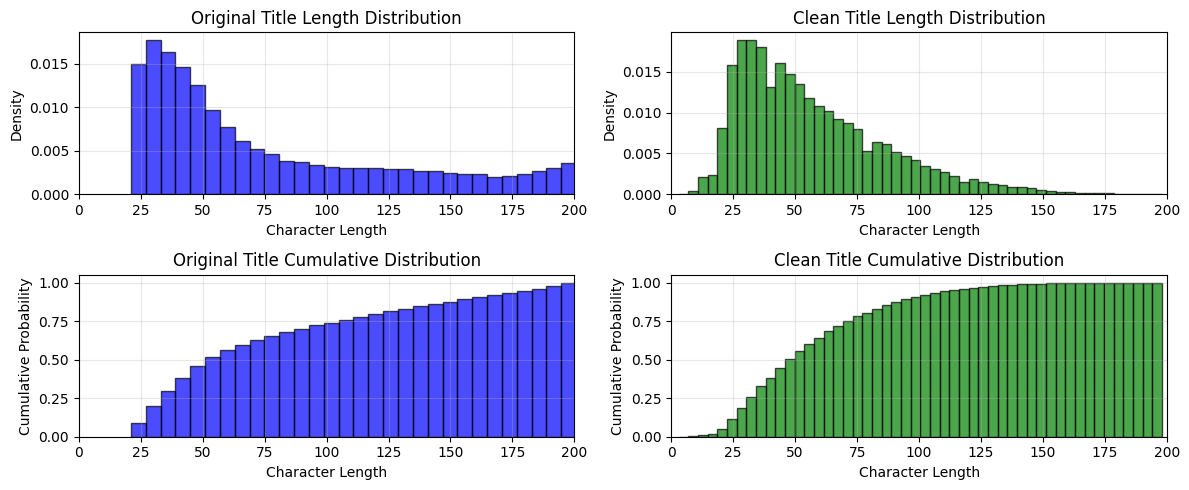

In [ ]:
# Create figure with 2x2 subplots
fig, axes = plt.subplots(2, 2, figsize=(12, 5))
X_AXIS_LIMIT = 200

# Convert to numpy arrays for plotting
original_lengths = item_df["original_title_length"].to_numpy()
clean_lengths = item_df["clean_title_length"].to_numpy()

# 1. Histogram with density for original descriptions
ax1 = axes[0, 0]
n1, bins1, patches1 = ax1.hist(original_lengths, bins=100, density=True, alpha=0.7, color="blue", edgecolor="black")
ax1.set_xlabel("Character Length")
ax1.set_ylabel("Density")
ax1.set_title("Original Title Length Distribution")
ax1.set_xlim(0, X_AXIS_LIMIT)  # Limit x-axis to 99th percentile for better visibility
ax1.grid(True, alpha=0.3)

# 2. Histogram with density for clean descriptions
ax2 = axes[0, 1]
n2, bins2, patches2 = ax2.hist(clean_lengths, bins=50, density=True, alpha=0.7, color="green", edgecolor="black")
ax2.set_xlabel("Character Length")
ax2.set_ylabel("Density")
ax2.set_title("Clean Title Length Distribution")
ax2.set_xlim(0, X_AXIS_LIMIT)  # Limit x-axis to 99th percentile for better visibility
ax2.grid(True, alpha=0.3)

# 3. Cumulative distribution for original descriptions
ax3 = axes[1, 0]
sorted_original = np.sort(original_lengths)
cumulative_original = np.arange(1, len(sorted_original) + 1) / len(sorted_original)
ax3.hist(sorted_original, bins=100, cumulative=True, density=True, alpha=0.7, color="blue", edgecolor="black")
ax3.set_xlabel("Character Length")
ax3.set_ylabel("Cumulative Probability")
ax3.set_title("Original Title Cumulative Distribution")
ax3.grid(True, alpha=0.3)
ax3.set_xlim(0, X_AXIS_LIMIT)  # Limit x-axis to 99th percentile for better visibility

# 4. Cumulative distribution for clean descriptions
ax4 = axes[1, 1]
sorted_clean = np.sort(clean_lengths)
cumulative_clean = np.arange(1, len(sorted_clean) + 1) / len(sorted_clean)
ax4.hist(sorted_clean, bins=50, cumulative=True, density=True, alpha=0.7, color="green", edgecolor="black")
ax4.set_xlabel("Character Length")
ax4.set_ylabel("Cumulative Probability")
ax4.set_title("Clean Title Cumulative Distribution")
ax4.grid(True, alpha=0.3)
ax4.set_xlim(0, X_AXIS_LIMIT)  # Limit x-axis to 99th percentile for better visibility

plt.tight_layout()
plt.show()

In [ ]:
# Get sample of clean descriptions with less than 200 chars, sorted by highest percentage reduction
short_clean_sample = (
    item_df.filter(pl.col("clean_desc_length") < 200)
    .sort("desc_reduction_prop", descending=True)
    .select(
        [
            "parent_asin",
            "title",
            "original_desc_length",
            "clean_desc_length",
            "desc_char_reduction",
            "desc_reduction_prop",
            "description_text",
            "clean_description",
        ]
    )
)
logger.info(f"Short clean sample: {len(short_clean_sample):,}")

pl.Config.set_fmt_str_lengths(500)
pl.Config.set_tbl_rows(50)
short_clean_sample.select(
    ["description_text", "clean_description", "original_desc_length", "clean_desc_length", "desc_reduction_prop"]
).head(5)

15:32:54 - Short clean sample: 3,857


description_text,clean_description,original_desc_length,clean_desc_length,desc_reduction_prop
str,str,i64,i64,f64
"""Amazon_WOS4engl p { margin: 0px; } h1 { margin: 0px; } h2 { margin: 0px; } h3 { margin: 0px; } html, body { width: 100%; height: 100%; margin: 0px; } body { transform: perspective(1400px) matrix3d(1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1); transform-style: preserve-3d; background-color: transparent; } .gwd-p-f2pf { position: absolute; font-family: 'Times New Roman'; color: rgb(0, 0, 0); transform-style: preserve-3d; left: 54px; top: 41px; width: 1141px; height: 17px; transform-origin: -13p…","""The product description was provided in a format that is not readable and appears to be an incomplete or corrupted data string. Therefore, no product features or details can be extracted or cleaned.""",5418,198,0.963455
"""This Bundle includes the following titles: The Typing of The Dead: Overkill The Typing of The Dead: Overkill The Typing of the Dead: Overkill - Dancing with the Dead DLC The Typing of the Dead: Overkill - Dancing with the Dead DLC The Typing of the Dead: Overkill - Filth DLC The Typing of the Dead: Overkill - Filth DLC Typing of the Dead: Overkill - Love at First Bite DLC Typing of the Dead: Overkill - Love at First Bite DLC The Typing of the Dead: Overkill - Silver Screen DLC The Typing of the …","""This bundle features ""The Typing of the Dead: Overkill"" along with its downloadable content: ""Dancing with the Dead,"" ""Filth,"" ""Love at First Bite,"" and ""Silver Screen.""""",1231,169,0.862713
"""Starter Protection Kit for Poke Ball Plus ( 2 in 1) If you want to protect your Poke Ball plus controller, you can choose this accessories kit for Pokemon poke ball plus. Carrying Case for Pokemon Lets Go Pokeball Plus It greatly fits for Poke ball plus controller. It has enough room for the cord and joystick. It is a harder shell that would protect the Pokeball plus from bumps and drops. You just need to zip it back up and have it be secure. You can clip it onto your pants or attach it to your…","""Protect your Pokémon Poke Ball Plus controller with this 2-in-1 Starter Protection Kit. The kit includes a durable carrying case and a silicone protective case.""",1045,160,0.84689
"""Jampack Volume 14 gives you a chance to see the hottest new PS2 games of '06 -- before they're released! Get in the know about the next wave of hot games! 1.4 billion texels/sec. fill rate 263 million vertices/sec. setup Maximum display resolution 2048 x 1536 @ 85Hz Flat-panel display support with resolutions up to 1920 x 1200 NVIDIA CineFX 3.0 engine - Full support for DirectX 9.0 Shader Model 3.0 delivers smoother and faster game play with stunning special effects UltraShadow II Technology enh…","""Jampack Volume 14 offers an exclusive preview of the hottest upcoming PS2 games of 2006. Stay ahead of the curve and discover the next generation of gaming titles before their official release.""",1184,193,0.836993
"""Game details From one of gaming’s most acclaimed sagas, Gears is bigger than ever, with five thrilling modes and the deepest campaign yet. Three-player Campaign Co-op: Battle alongside your friends in three-player online or split-screen co-op. Tours of Duty: Rank up from new recruit to four-star general in Gears Tours of Duty. Take on new and exciting challenges, earn awesome rewards and show off your loot. Boot Camp: New to Gears or just a little rusty? Bootcamp is a fun way to learn the ropes,…","""Embark on an epic adventure with Gears, now bigger and more immersive than ever. This installment features five thrilling modes and the deepest campaign to date.""",782,161,0.794118


In [ ]:
pl.Config.set_fmt_str_lengths(1000)
item_df.sort("desc_char_reduction", descending=True).select(
    [
        "description_text",
        "clean_description",
        "original_desc_length",
        "clean_desc_length",
        "desc_char_reduction",
        "desc_reduction_prop",
    ]
).head(5)

description_text,clean_description,original_desc_length,clean_desc_length,desc_char_reduction,desc_reduction_prop
str,str,i64,i64,i64,f64
"""Product description The PSP (PlayStation Portable) system is the first truly integrated portable entertainment system designed to handle multiple applications - music, video, photo, internet, and wireless connectivity, with games as its key feature. The PSP system features an unmatched library of entertainment content, combining more than 135 games and more than 430 feature films, TV programs, and videos on UMD from major studios and record labels, as well as downloadable content from the internet. The PSP is more than a portable game system, it's a lifestyle. Like life, it is constantly evolving - moving towards newer levels of technology and entertainment. This special pack is a great way to join the fun! Dazzling widescreen LCD brings gaming to life With Wi-Fi functionality you can go online with your PSP or communicate directly with other PSP systems. Play games online, browse the web and more. Daxter gives the co-star of the popular Jak & Daxter games his own adventure! Play from …","""The PlayStation Portable (PSP) is a revolutionary handheld entertainment system offering games, music, video, photos, and internet access. Its standout feature is a dazzling 4.3-inch widescreen LCD display that brings games to life with graphics comparable to the PlayStation 2. Connect wirelessly via Wi-Fi to browse the web and play games with others. This special pack includes ""Daxter,"" a unique platformer where you play as the witty ottsel from the Jak & Daxter series. Navigate Haven City from Daxter's perspective, utilizing agile abilities like crawling and fitting into small spaces. The PSP utilizes high-capacity Universal Media Discs (UMDs) for content, supporting over 135 games and hundreds of films, TV programs, and videos.""",93558,740,92818,0.99209
"""Product description Haven't joined the PSP generation yet? This PSP Limited Edition Star Wars Battlefront Pack is ready to help you launch. The PSP (PlayStation Portable) system is the first truly integrated portable entertainment system designed to handle multiple applications - music, video, photo, internet, and wireless connectivity, with games as its key feature. The PSP system features an unmatched library of entertainment content, combining more than 135 games and more than 430 feature films, TV programs, and videos on UMD from major studios and record labels, as well as downloadable content from the internet. It is constantly evolving to fit your lifestyle - on the web, as MP3 or MP4 player, go WiFi, and beyond. Great games and graphics display on bright integrated widescreen. Uses MemoryStick Pro storage. With PSP, the force will be with you! Amazon.com PSP is the first truly integrated handheld entertainment system designed to handle multiple applications — music, video, commu…","""Embark on your portable gaming journey with the PSP Limited Edition Star Wars Battlefront Pack. This integrated handheld system redefines on-the-go entertainment, seamlessly blending gaming with music, video, photo viewing, and internet connectivity. Immerse yourself in a rich library of over 135 games and 430 movies, TV programs, and videos on UMD, with the option for downloadable content. Experience unparalleled gaming with graphics comparable to PlayStation 2, all displayed on a brilliant 4.3-inch widescreen TFT display. The pack includes the PSP system in Ceramic White, AC power cord, AC adapter, battery, and the Star Wars Battlefront: Renegade Squadron game. The PSP utilizes the high-capacity Universal Media Disc (UMD) for its storage medium, ensuring you have plenty of space for your entertainment needs.""",93108,821,92287,0.991182
"""Product description Open the door to a whole new world of learning at home and on the go with JumpStart Advanced Premium 1st Grade. It's designed to make it easier for you to take learning beyond the computer and keep you

In [ ]:
# Get sample of clean descriptions with less than 200 chars, sorted by highest percentage reduction
short_clean_sample = (
    item_df.filter(pl.col("clean_title_length") < 200)
    .sort("title_reduction_prop", descending=True)
    .select(
        [
            "parent_asin",
            "original_title_length",
            "clean_title_length",
            "title_char_reduction",
            "title_reduction_prop",
            "title",
            "clean_title",
        ]
    )
)
logger.info(f"Short clean sample: {len(short_clean_sample):,}")

pl.Config.set_fmt_str_lengths(500)
pl.Config.set_tbl_rows(50)
short_clean_sample.select(
    ["title", "clean_title", "original_title_length", "clean_title_length", "title_reduction_prop"]
).head(5)

15:32:54 - Short clean sample: 66,097


title,clean_title,original_title_length,clean_title_length,title_reduction_prop
str,str,i64,i64,f64
"""Shu (Free Trial) [Download]""","""Shu""",27,3,0.888889
"""GKG SEGA SATURN RGB SCART LEAD CABLE Mouse over image to zoom RGB-Scart-AV-Cable-Lead-for-Sega-Saturn-Games-Console-Stereo-Sound-NEW RGB-Scart-AV-Cable-Lead-for-Sega-Saturn-Games-Console-Stereo-Sound-NEW RGB Scart AV Cable Lead for Sega Saturn Games Console - Stereo Sound""","""GKG Sega Saturn RGB SCART Cable""",272,31,0.886029
"""Sentey® Gaming Headset Red Arrow Analog 3.5mm In-line Volume Control & Computer Headset with Microphone Gaming Headphones Headphone Pc, Mac or Laptop, Tablet, Mobile Phones / Headset with Mic Heavy Duty Braided 2 Meters Cable / Leather Padded Ear Pads with Passive Noise Canceling / Computer Gaming Headset Ergonomic Adaptive Leather Headband (Extreme Comfort) - Computer Gaming Headset Stereo Left and Right Drivers 40mm / Cap Connector / Computer Headset to Work and Play / Skype Headset - Gaming H…","""Sentey Red Arrow Analog Gaming Headset with Microphone & 3.5mm Jack""",533,67,0.874296
"""Vr Quest 2 Head Strap, Quest 2 Halo Strap, Quest 2 Head Strap, Quest 2 Elite Strap, Vr Quest 2 Elite Strap, Halo Strap Quest 2 ,vr Head Strap""","""Quest 2 Halo Strap""",141,18,0.87234
"""Battle Born For PS4 | 2016 | Playstation 4 | Electronic Art's| Dual Shock 4 | 1-10 Players| Remote Play/Online Play | English-USA Version| 2k/Take 2 Video Games | From The Creators Of Borderlands| New""","""Battle Born for PS4 | 2016""",200,26,0.87


In [ ]:
pl.Config.set_fmt_str_lengths(1000)
item_df.sort("title_char_reduction", descending=True).select(
    [
        "title",
        "clean_title",
        "original_title_length",
        "clean_title_length",
        "title_char_reduction",
        "title_reduction_prop",
    ]
).head(5)

title,clean_title,original_title_length,clean_title_length,title_char_reduction,title_reduction_prop
str,str,i64,i64,i64,f64
"""Gaming Keyboard Blue LED Backlit Sentey® Phoenix Gs-5700 / Blue Led Lightning Illuminated Key's / Replaceable Orange Gaming Keys Wasd / 114 Keys / 7 Macrokeys / Software / Carry Bag for Transport / Extreme Series / 8 Rollover Keys / 50 Million Times / 50g Acuation Force / 128k On-board Memory to Record Profiles / 3 Different Levels of Light Brightness / Windows Lock Key Feature / 3 Profiles Setup / 1.8 All Braided Cable / USB 2.0 Gold Plated USB Connector / All Black Rubber Coating Painting / Weight 663.5g (1.46lbs) / Cable Management with Velcro Straps / USB Cap Connector - Connector Cap / Keycap Laser Engraving""","""Sentey Phoenix GS-5700 Gaming Keyboard - Blue LED Backlit, Replaceable Orange WASD Keys, 114 Keys, 7 Macro Keys, Software, Includes Carry Bag""",620,141,479,0.772581
"""Sentey® Gaming Headset Red Arrow Analog 3.5mm In-line Volume Control & Computer Headset with Microphone Gaming Headphones Headphone Pc, Mac or Laptop, Tablet, Mobile Phones / Headset with Mic Heavy Duty Braided 2 Meters Cable / Leather Padded Ear Pads with Passive Noise Canceling / Computer Gaming Headset Ergonomic Adaptive Leather Headband (Extreme Comfort) - Computer Gaming Headset Stereo Left and Right Drivers 40mm / Cap Connector / Computer Headset to Work and Play / Skype Headset - Gaming Headsets for Chat and Play Gs-4521""","""Sentey Red Arrow Analog Gaming Headset with Microphone & 3.5mm Jack""",533,67,466,0.874296
"""Sentey® Gaming Headset Blue Arrow Analog 3.5mm In-line Volume Control & Computer Headset with Microphone Gaming Headphones Headphone Pc, Mac or Laptop, Tablet, Mobile Phones / Headset with Mic Heavy Duty Braided 2 Meters Cable / Leather Padded Ear Pads with Passive Noise Canceling / Computer Gaming Headset Ergonomic Adaptive Leather Headband (Extreme Comfort) - Computer Gaming Headset Stereo Left and Right Drivers 40mm / Cap Connector / Computer Headset to Work and Play / Skype Headset - Gaming Headsets for Chat and Play Gs-4520""","""Sentey Blue Arrow Gaming Headset with Microphone - Analog 3.5mm, In-line Volume Control for PC, Mac, Laptop, Tablet, Mobile""",534,123,411,0.769663
"""ARDOUR VAN YSECTLAABBCC Tekken Tag Tournament 2 Video Game for Playstation 3 / PS3! Walmart Exclusive Version with Bonus Mini Strategy Guide and Playstation Network Theme!ARDOUR VAN YSECTLAABBCC Tekken Tag Tournament 2 Video Game for Playstation 3 / PS3! Walmart Exclusive Version with Bonus Mini Strategy Guide and Playstation Network Theme!ARDOUR VAN YSECTLAABBCC Tekken Tag Tournament 2 Video Game for Playstation 3 / PS3! Walmart Exclusive Version with Bonus Mini Strategy""","""Ardor Van Tekken Tag Tournament 2 Video Game for Playstation 3 / PS3 (Walmart Exclusive)""",476,88,388,0.815126
"""Genuine Dell UN733 Wireless Bluetooth Optical Mouse With Scroll Wheel. Compatible with Computer PC Desktops, Laptop and Notebook Systems, Playstation 3 gaming console, Android Tablets: Samsung Galaxy Tab 10.1, Motorola Xoom, Asus Eee Transformer, Acer Iconica, Toshiba Thrive, and any system with built in Bluetooth or using an external receiver (receiver NOT Included). Compatible Part Numbers: DH421, G480K, DH956""","""Dell UN733 Wireless Bluetooth Optical Mouse with Scroll Wheel""",415,61,354,0.853012


In [ ]:
pl.Config.restore_defaults()
item_df = item_df.rename(
    {
        "description_text": "original_description",
        "clean_description": "description_text",
        "title": "original_title",
        "clean_title": "title",
    }
)
item_df.head()

parent_asin,original_title,original_description,features_text,main_category,categories_text,store,average_rating,rating_number,price,item_context,description_text,title,product_type,platform,genre,hardware_type,brand,multiplayer,franchise,original_desc_length,clean_desc_length,original_title_length,clean_title_length,desc_char_reduction,desc_reduction_prop,title_char_reduction,title_reduction_prop
str,str,str,str,str,str,str,str,i64,str,str,str,str,str,list[str],list[str],str,str,str,str,i64,i64,i64,i64,i64,f64,i64,f64
"""B005FSHPVO""","""Snark Busters: All Revved Up […","""From the Manufacturer Snark Bu…","""""","""Video Games""","""Video Games > PC > Games""","""Alawar Entertainment""","""3.0""",2,"""6.99""","""Product: Snark Busters: All Re…","""Embark on an adventure with Ja…","""Snark Busters: All Revved Up (…","""Game""","[""PC""]","[""Adventure"", ""Puzzle"", … ""Point-and-Click""]",null,null,"""Single-player""","""Snark Busters""",901,922,43,43,-21,-0.023307,0,0.0
"""B01940J462""","""Beach Buggy Racing - PS4 [Digi…","""Beach Buggy is back with an ex…","""""","""Video Games""","""Video Games > PlayStation Digi…","""Vector Unit""","""4.1""",48,"""""","""Product: Beach Buggy Racing - …","""Experience explosive off-road …","""Beach Buggy Racing - PS4 Digit…","""Game""","[""PS4""]","[""Racing"", ""Kart Racing"", ""Action""]",null,null,"""Single-player, Local Co-op, Co…","""Beach Buggy""",794,680,39,37,114,0.143577,2,0.051282
"""B008U2XILI""","""Rock Candy Xbox 360 Controller…","""Color is expression! Discover …","""Available in assorted tinted a…","""Video Games""","""Video Games > Legacy Systems >…","""PDP""","""3.3""",113,"""79.99""","""Product: Rock Candy Xbox 360 C…","""Express your gaming personalit…","""Rock Candy Xbox 360 Controller…","""Accessory""","[""Xbox 360""]",null,"""Controller""","""Rock Candy""",null,null,542,393,39,39,149,0.274908,0,0.0
"""B09ZKMNQNV""","""MOJOXR 16FT C to C Fiber-Optic…","""16FT C to C Fiber-Optic Link C…","""Unlock More PC Games: Connect …","""Cell Phones & Accessories""","""Video Games > PC > Accessories""","""MOJOXR""","""5.0""",6,"""49.99""","""Product: MOJOXR 16FT C to C Fi…","""This 16-foot USB-C to USB-C fi…","""MOJOXR 16ft C to C Fiber-Optic…","""Accessory""","[""PC"", ""Quest 2"", … ""MacBook Pro""]",null,"""Cable""","""MOJOXR""",null,null,180,351,186,142,-171,-0.95,44,0.236559
"""B07H517Z9Q""","""Motorstorm Apocalypse (Renewed…","""Welcome to the apocalypse, Mot…","""This Certified Refurbished pro…","""""","""Video Games > Legacy Systems >…","""Amazon Renewed""","""3.2""",3,"""""","""Product: Motorstorm Apocalypse…","""Experience the MotorStorm fest…","""Motorstorm Apocalypse (Renewed…","""Game""","[""PlayStation 3""]","[""Racing"", ""Action""]",null,"""MotorStorm""","""Single-player, Local Co-op, On…","""MotorStorm""",1201,853,31,31,348,0.289759,0,0.0


In [ ]:
# Coalesce categories
item_df = item_df.with_columns(
    pl.when(pl.col("categories_text") == "")
    .then(pl.col("main_category"))
    .otherwise(pl.col("categories_text"))
    .alias("categories_text")
)

assert len(item_df.filter(pl.col("categories_text") == "").select(["categories_text", "main_category"])) == 0

In [ ]:
# Create item_context with augmented metadata
context_parts = [
    pl.lit("Product: "),
    pl.col("title"),
    pl.lit("\nDescription: "),
    pl.col("description_text"),
    pl.lit("\nCategory: "),
    pl.col("categories_text"),
]

# Add augmented metadata if available
if "product_type" in item_df.columns:
    context_parts.extend(
        [
            pl.lit("\nProduct Type: "),
            pl.col("product_type").fill_null("Unknown"),
        ]
    )

if "platform" in item_df.columns:
    context_parts.extend(
        [
            pl.lit("\nPlatform: "),
            pl.col("platform").list.join(", ").fill_null("N/A"),
        ]
    )

if "genre" in item_df.columns:
    context_parts.extend(
        [
            pl.lit("\nGenre: "),
            pl.col("genre").list.join(", ").fill_null("N/A"),
        ]
    )

if "brand" in item_df.columns:
    context_parts.extend(
        [
            pl.lit("\nBrand: "),
            pl.col("brand").fill_null("Unknown"),
        ]
    )

if "multiplayer" in item_df.columns:
    context_parts.extend(
        [
            pl.lit("\nMultiplayer: "),
            pl.col("multiplayer").fill_null("Unknown"),
        ]
    )

if "franchise" in item_df.columns:
    context_parts.extend(
        [
            pl.lit("\nFranchise: "),
            pl.col("franchise").fill_null("N/A"),
        ]
    )

item_df = item_df.with_columns(pl.concat_str(context_parts).alias("item_context"))

pl.Config.set_fmt_str_lengths(1000)
item_df.select(["item_context"]).head(5)

item_context
str
"""Product: Snark Busters: All Revved Up (Mac Download) Description: Embark on an adventure with Jack Blair, a world-famous racecar driver, in Snark Busters 2: All Revved Up. Jack pauses his career to pursue the elusive Snark, venturing between the real world and mirror realms to catch his quarry. This game features: * **Engaging Gameplay:** Solve dozens of whimsical puzzles, explore exquisitely detailed worlds, and discover hundreds of cleverly hidden objects. * **Rich Content:** Experience six chapters across 31 unique locations, filled with 21 mini-games, animated cinematics, and clickable surprises. * **Helpful Features:** Benefit from unlimited hints and tips, and a learn-as-you-play tutorial to guide your progress. Snark Busters 2 promises an unforgettable ride through a world of imagination and mystery. **Minimum System Requirements:** * **OS:** Mac OS X 10.5 or higher * **Processor:** 1 GHz (Intel only) * **RAM:** 512 MB * **Hard Drive:** 296 MB * **Video Card:** 32 MB Category: V…"
"""Product: Beach Buggy Racing - PS4 Digital Code Description: Experience explosive off-road kart racing mayhem with Beach Buggy's action-packed sequel. Compete against unique rival drivers, each boasting special abilities, and collect a variety of powerups, including Dodgeball Frenzy, Fireball, and Oil Slick. Unlock and upgrade an impressive garage of vehicles, from agile dune buggies to powerful monster trucks. Test your driving prowess across 15 imaginative 3D race tracks, mastering 6 distinct game modes. Challenge up to 4 friends in split-screen multiplayer for thrilling head-to-head competition. Enjoy a rock-solid 60fps performance in stunning 1080p clarity. A PlayStation account is required for game activation and installation. Category: Video Games > PlayStation Digital Content > Games Product Type: Game Platform: PS4 Genre: Racing, Kart Racing, Action Brand: Unknown Multiplayer: Single-player, Local Co-op, Couch Co-op Franchise: Beach Buggy"""
"""Product: Rock Candy Xbox 360 Controller - Purple Description: Express your gaming personality with the officially licensed Rock Candy Wired Controller for Xbox 360. Choose from vibrant colors to match your style: * **Blue:** Cool, calculating, and focused on victory. * **Green:** Naturally talented and elegant. * **Pink:** Wild, free-spirited, and ready to explore new gaming worlds. Escape dull peripheral choices and showcase your unique gaming style. Category: Video Games > Legacy Systems > Xbox Systems > Xbox 360 > Accessories > Controllers > Gamepads & Standard Controllers Product Type: Accessory Platform: Xbox 360 Genre: N/A Brand: Rock Candy Multiplayer: Unknown Franchise: N/A"""
"""Product: MOJOXR 16ft C to C Fiber-Optic Link Cable for Quest 2/Pro, Gaming PC, MacBook Pro - USB 3.2 Gen 2 10Gbps, 3A Fast Charging, with USB-A Adapter Description: This 16-foot USB-C to USB-C fiber-optic cable offers a robust connection for Quest 2 gaming PCs and MacBook Pros. It supports USB 3.2 Gen 2 for high-speed data transfer up to 10 Gbps, ensuring smooth gameplay and rapid file sharing. The cable also provides 3A fast charging capabilities. Included is a USB-C to USB-A adapter for broader compatibility. Category: Video Games > PC > Accessories Product Type: Accessory Platform: PC, Quest 2, Quest Pro, MacBook Pro Genre: N/A Brand: MOJOXR Multiplayer: Unknown Franchise: N/A"""
"""Product: Motorstorm Apocalypse (Renewed) Description: Experience the MotorStorm festival in a post-apocalyptic metropolis devastated by an earthquake. Navigate unstable skyscrapers, fiery subway tunnels, and twisting bridges in this brutal street racing environment. Real-time tremors and aftershocks constantly alter the race course, adding an unpredictable element to every event. Choose and customize from 13 vehicle classes, including supercars, muscle cars, superbikes, and choppers, alongside classic MotorStorm favorites. Survive intense, real-time destruction effects, from gunfire and rocket attacks to ongo

In [ ]:
item_df.select(["original_title", "original_description", "title", "description_text"]).head(5)

original_title,original_description,title,description_text
str,str,str,str
"""Snark Busters: All Revved Up [Mac Download]""","""From the Manufacturer Snark Busters 2: All Revved Up tells the incredible story of Jack Blair, a world famous racecar driver who puts his career on hold to catch the Snark. Join Jack as he jumps between the real world and the inverted realms inside of mirrors in an attempt to catch his quarry. Solve dozens of whimsical puzzles; explore worlds of exquisite detail; and keep your eyes peeled for hundreds of cleverly hidden objects! Packed with mini-games, animated cinematics, and clickable surprises, Snark Busters 2 offers a ride you'll never forget! Six chapters Six chapters 31 locations 31 locations 21 mini-games 21 mini-games Unlimited hints and tips Unlimited hints and tips Learn-as-you-play tutorial Learn-as-you-play tutorial System Requirements Minimum Specifications: OS:Mac OS X 10.5 or higher Processor:1 GHz (INTEL ONLY) RAM:512 MB Hard Drive:296 Video Card:32 MB Additional Info:None""","""Snark Busters: All Revved Up (Mac Download)""","""Embark on an adventure with Jack Blair, a world-famous racecar driver, in Snark Busters 2: All Revved Up. Jack pauses his career to pursue the elusive Snark, venturing between the real world and mirror realms to catch his quarry. This game features: * **Engaging Gameplay:** Solve dozens of whimsical puzzles, explore exquisitely detailed worlds, and discover hundreds of cleverly hidden objects. * **Rich Content:** Experience six chapters across 31 unique locations, filled with 21 mini-games, animated cinematics, and clickable surprises. * **Helpful Features:** Benefit from unlimited hints and tips, and a learn-as-you-play tutorial to guide your progress. Snark Busters 2 promises an unforgettable ride through a world of imagination and mystery. **Minimum System Requirements:** * **OS:** Mac OS X 10.5 or higher * **Processor:** 1 GHz (Intel only) * **RAM:** 512 MB * **Hard Drive:** 296 MB * **Video Card:** 32 MB"""
"""Beach Buggy Racing - PS4 [Digital Code]""","""Beach Buggy is back with an explosive sequel! Drive into an action-packed, surprise-filled world of off-road kart racing mayhem. Race against a field of rival drivers, each with unique personalities and special abilities. Build a collection of crazy powerups, like Dodgeball Frenzy, Fireball, and Oil Slick. Unlock and upgrade a variety of cars, from dune buggies to monster trucks. Test your skills in 6 different game modes on 15 imaginative 3D race tracks, against a pack of tropical-loving rivals with a serious case of road rage! Race shoulder-to-shoulder with up to 4 friends on one screen! Rock-solid 60fps in crystal clear 1080p. System Requirements: Supported Platforms: PlayStation 4 Supported Platforms: PlayStation 4 PlayStation account required for game activation and installation""","""Beach Buggy Racing - PS4 Digital Code""","""Experience explosive off-road kart racing mayhem with Beach Buggy's action-packed sequel. Compete against unique rival drivers, each boasting special abilities, and collect a variety of powerups, including Dodgeball Frenzy, Fireball, and Oil Slick. Unlock and upgrade an impressive garage of vehicles, from agile dune buggies to powerful monster trucks. Test your driving prowess across 15 imaginative 3D race tracks, mastering 6 distinct game modes. Challenge up to 4 friends in split-screen multiplayer for thrilling head-to-head competition. Enjoy a rock-solid 60fps performance in stunning 1080p clarity. A PlayStation account is required for game activation and installation."""
"""Rock Candy Xbox 360 Controller - Purple""","""Color is expression! Discover what flavor gamer you are with a Rock Candy Wired Controller. Are you blue - cool, calculating, and quietly marching toward victory? Are you naturally talented and elegantly green? Or are you the kind of wild, free spirit in pink just aching to break out across uncharted gaming worlds? With the Rock Candy controller, an officiall

In [ ]:
METADATA_COLS = [
    "parent_asin",
    "title",
    "description_text",
    "features_text",
    "main_category",
    "categories_text",
    "store",
    "average_rating",
    "rating_number",
    "price",
    # Augmented metadata columns
    "product_type",
    "platform",
    "genre",
    "hardware_type",
    "brand",
    "multiplayer",
    "franchise",
    # Context column
    "item_context",
]

# Filter to only include columns that exist in the dataframe
available_cols = [col for col in METADATA_COLS if col in item_df.columns]

item_df = item_df.select(available_cols)
logger.info(f"Selected {len(available_cols)} columns from metadata")
logger.info(f"Total items: {len(item_df):,}")
item_df.head()

15:32:54 - Selected 18 columns from metadata
15:32:54 - Total items: 66,097


parent_asin,title,description_text,features_text,main_category,categories_text,store,average_rating,rating_number,price,product_type,platform,genre,hardware_type,brand,multiplayer,franchise,item_context
str,str,str,str,str,str,str,str,i64,str,str,list[str],list[str],str,str,str,str,str
"""B005FSHPVO""","""Snark Busters: All Revved Up (Mac Download)""","""Embark on an adventure with Jack Blair, a world-famous racecar driver, in Snark Busters 2: All Revved Up. Jack pauses his career to pursue the elusive Snark, venturing between the real world and mirror realms to catch his quarry. This game features: * **Engaging Gameplay:** Solve dozens of whimsical puzzles, explore exquisitely detailed worlds, and discover hundreds of cleverly hidden objects. * **Rich Content:** Experience six chapters across 31 unique locations, filled with 21 mini-games, animated cinematics, and clickable surprises. * **Helpful Features:** Benefit from unlimited hints and tips, and a learn-as-you-play tutorial to guide your progress. Snark Busters 2 promises an unforgettable ride through a world of imagination and mystery. **Minimum System Requirements:** * **OS:** Mac OS X 10.5 or higher * **Processor:** 1 GHz (Intel only) * **RAM:** 512 MB * **Hard Drive:** 296 MB * **Video Card:** 32 MB""","""""","""Video Games""","""Video Games > PC > Games""","""Alawar Entertainment""","""3.0""",2,"""6.99""","""Game""","[""PC""]","[""Adventure"", ""Puzzle"", … ""Point-and-Click""]",null,null,"""Single-player""","""Snark Busters""","""Product: Snark Busters: All Revved Up (Mac Download) Description: Embark on an adventure with Jack Blair, a world-famous racecar driver, in Snark Busters 2: All Revved Up. Jack pauses his career to pursue the elusive Snark, venturing between the real world and mirror realms to catch his quarry. This game features: * **Engaging Gameplay:** Solve dozens of whimsical puzzles, explore exquisitely detailed worlds, and discover hundreds of cleverly hidden objects. * **Rich Content:** Experience six chapters across 31 unique locations, filled with 21 mini-games, animated cinematics, and clickable surprises. * **Helpful Features:** Benefit from unlimited hints and tips, and a learn-as-you-play tutorial to guide your progress. Snark Busters 2 promises an unforgettable ride through a world of imagination and mystery. **Minimum System Requirements:** * **OS:** Mac OS X 10.5 or higher * **Processor:** 1 GHz (Intel only) * **RAM:** 512 MB * **Hard Drive:** 296 MB * **Video Card:** 32 MB Category: V…"
"""B01940J462""","""Beach Buggy Racing - PS4 Digital Code""","""Experience explosive off-road kart racing mayhem with Beach Buggy's action-packed sequel. Compete against unique rival drivers, each boasting special abilities, and collect a variety of powerups, including Dodgeball Frenzy, Fireball, and Oil Slick. Unlock and upgrade an impressive garage of vehicles, from agile dune buggies to powerful monster trucks. Test your driving prowess across 15 imaginative 3D race tracks, mastering 6 distinct game modes. Challenge up to 4 friends in split-screen multiplayer for thrilling head-to-head competition. Enjoy a rock-solid 60fps performance in stunning 1080p clarity. A PlayStation account is required for game activation and installation.""","""""","""Video Games""","""Video Games > PlayStation Digital Content > Games""","""Vector Unit""","""4.1""",48,"""""","""Game""","[""PS4""]","[""Racing"", ""Kart Racing"", ""Action""]",null,null,"""Single-player, Local Co-op, Couch Co-op""","""Beach Buggy""","""Product: Beach Buggy Racing - PS4 Digital Code Description: Experience explosive off-road kart racing mayhem with Beach Buggy's action-packed sequel. Compete against unique rival drivers, each boasting special abilities, and collect a variety of powerups, including Dodgeball Frenzy, Fireball, and Oil Slick. Unlock and upgrade an impressive garage of vehicles, from agile dune buggies to powerful monster trucks. Test your driving prowess across 15 imaginative 3D race

In [ ]:
# SAVE UPDATED METADATA
updated_metadata_output_path = DATA_DIR / "output" / f"{CATEGORY}_items_updated.parquet"
item_df.write_parquet(updated_metadata_output_path)
logger.info(f"Saved updated metadata to {updated_metadata_output_path}")

15:32:54 - Saved updated metadata to /Users/eugeneyan/projects/semantic-id/data/output/Video_Games_items_updated.parquet


## Update sequences

In [ ]:
# Load the gzipped CSV file
df = pl.read_csv(f"../data/{CATEGORY}.train.csv.gz")

# Display basic information about the dataset
logger.info(f"Dataset shape: {df.shape}")
logger.info(f"Columns: {df.columns}")

df.head()

15:32:54 - Dataset shape: (736827, 5)
15:32:54 - Columns: ['user_id', 'parent_asin', 'rating', 'timestamp', 'history']


user_id,parent_asin,rating,timestamp,history
str,str,f64,i64,str
"""AEVPPTMG43C6GWSR7I2UGRQN7WFQ""","""B08R5B7YS4""",1.0,1611459666223,null
"""AEVPPTMG43C6GWSR7I2UGRQN7WFQ""","""B0863MT183""",4.0,1613701986538,"""B08R5B7YS4"""
"""AEVPPTMG43C6GWSR7I2UGRQN7WFQ""","""B08P8P7686""",5.0,1613702112995,"""B08R5B7YS4 B0863MT183"""
"""AEVPPTMG43C6GWSR7I2UGRQN7WFQ""","""B0B7LV3DN2""",4.0,1617641445475,"""B08R5B7YS4 B0863MT183 B08P8P7686"""
"""AEVPPTMG43C6GWSR7I2UGRQN7WFQ""","""B09WMQ6DXG""",5.0,1620231368468,"""B08R5B7YS4 B0863MT183 B08P8P7686 B0B7LV3DN2"""


In [ ]:
# Deduplicate by user_id, keeping the row with the longest history
# First, calculate the length of each history
df = df.with_columns(
    pl.when(pl.col("history").is_null())
    .then(0)
    .otherwise(pl.col("history").str.count_matches(r"\S+"))
    .alias("history_length")
)

logger.info(f"Original dataset num rows: {df.shape[0]:,}")

# Sort by user_id and history_length (descending), then keep first row per user
df = df.sort(["user_id", "history_length"], descending=[False, True]).group_by("user_id").first().drop("history_length")

logger.info(f"Deduplicated dataset num rows: {df.shape[0]:,}")
logger.info(f"Number of unique users: {df.n_unique('user_id'):,}")

15:32:54 - Original dataset num rows: 736,827
15:32:54 - Deduplicated dataset num rows: 91,562
15:32:54 - Number of unique users: 91,562


In [ ]:
# Create sequences column by appending parent_asin to history as a list
df = df.with_columns(pl.col("history").str.split(" ").list.concat([pl.col("parent_asin")]).alias("sequence"))
valid_items = set(item_df["parent_asin"].to_list())

df.head()

user_id,parent_asin,rating,timestamp,history,sequence
str,str,f64,i64,str,list[str]
"""AE222HFZDH6BPTYFOUWGGU63YSIQ""","""B0BW17W9GM""",5.0,1593366227132,"""B082R1RGZF B07SNN8GV5 B01GY35T4S B07QX99XJJ""","[""B082R1RGZF"", ""B07SNN8GV5"", … ""B0BW17W9GM""]"
"""AE2252DKW4XJIZP5QPFMQVJBVRTA""","""B07JH3LSHN""",5.0,1562210954523,"""B0050SX4CI B002ORTCAQ B0090ECASW B004OYV7ZU B00F27JGVA B01N6N3J8D B01KV3BB0S B0C5K2TWD8""","[""B0050SX4CI"", ""B002ORTCAQ"", … ""B07JH3LSHN""]"
"""AE225O22SA7DLBOGOEIFL7FT5VYQ""","""B0053BCML6""",4.0,1370812046000,"""B00005YTYC B00029QOQS B0006B7DXA B001LETH2Q B0009XEC02 B000NNDN1M B00136MBHA B007VTVRFA""","[""B00005YTYC"", ""B00029QOQS"", … ""B0053BCML6""]"
"""AE227CCN4C37WTOB3J2TZPOKLEQQ""","""B001QCWRWK""",1.0,1442558286000,"""B0049U4DXM B002V8KA72 B0000NSZMM B000KQLDP0 B0032C9V7G B001EYUPHO B000WCCURW B00LZVNWIA B00AYZMZ9K B000IGE78M""","[""B0049U4DXM"", ""B002V8KA72"", … ""B001QCWRWK""]"
"""AE22BPPZGGRTSYOHK2J3LCG5HGAQ""","""B0053BCML6""",5.0,1418058672000,"""B00KVP3OY8 B07K3KHFSY B00KVP76G0 B00KVOVBGM""","[""B00KVP3OY8"", ""B07K3KHFSY"", … ""B0053BCML6""]"


In [ ]:
valid_items = set(item_df["parent_asin"].to_list())


# Filter items without metadata
def filter_sequence_items(sequence_list, valid_items_set):
    if sequence_list is None:
        return None

    # Filter the list to keep only items with valid metadata
    filtered_items = [item for item in sequence_list if item in valid_items_set]

    return filtered_items if filtered_items else None


# Filter sequences where metadata is missing
df = df.with_columns(
    pl.col("sequence")
    .map_elements(lambda x: filter_sequence_items(x, valid_items), return_dtype=pl.List(pl.String))
    .alias("sequence")
)

# Filter out rows where:
# 1. The target item (parent_asin) doesn't have valid metadata
# 2. The filtered sequences is empty or null
rows_before_filtering = df.shape[0]
logger.info(f"Rows before filtering: {rows_before_filtering:,}")

df = df.filter((pl.col("sequence").is_not_null()) & (pl.col("sequence").list.len() >= MIN_SEQUENCE_LENGTH))

# Log statistics
logger.info(f"Rows after filtering: {df.shape[0]:,}")
logger.info(
    f"Rows removed: {rows_before_filtering - df.shape[0]:,} ({(rows_before_filtering - df.shape[0]) / rows_before_filtering * 100:.1f}%)"
)

15:32:55 - Rows before filtering: 91,562
15:32:55 - Rows after filtering: 78,627
15:32:55 - Rows removed: 12,935 (14.1%)


In [ ]:
# Truncate long sequences
# Calculate sequence lengths before truncation
df = df.with_columns(pl.col("sequence").list.len().alias("sequence_length_before"))

# Using Polars expressions for efficient truncation - take last N items
df = df.with_columns(pl.col("sequence").list.tail(MAX_SEQUENCE_LENGTH).alias("sequence"))

# Update sequence length for truncated sequences
df = df.with_columns(pl.col("sequence").list.len().alias("sequence_length"))

# Calculate truncation statistics
sequences_truncated = (df["sequence_length_before"] > MAX_SEQUENCE_LENGTH).sum()
pct_truncated = sequences_truncated / len(df) * 100

logger.info(f"Sequences truncated: {sequences_truncated:,} ({pct_truncated:.1f}%)")

# Replace the sequences column with the truncated version
df = df.drop(["sequence_length_before"])

logger.info(
    f"Sequence lengths - Min: {df['sequence_length'].min()}, Max: {df['sequence_length'].max()}, Mean: {df['sequence_length'].mean():.1f}, Median: {df['sequence_length'].median()}"
)

15:32:55 - Sequences truncated: 28 (0.0%)
15:32:55 - Sequence lengths - Min: 3, Max: 100, Mean: 6.5, Median: 5.0


In [ ]:
df.group_by("sequence_length").len().with_columns((pl.col("len") / pl.sum("len")).alias("probability")).sort(
    "sequence_length"
).with_columns(pl.col("probability").cum_sum().alias("cumulative_probability")).head(10)

sequence_length,len,probability,cumulative_probability
u32,u32,f64,f64
3,13154,0.167296,0.167296
4,17459,0.222048,0.389345
5,15689,0.199537,0.588882
6,9280,0.118026,0.706907
7,5881,0.074796,0.781703
8,4014,0.051051,0.832755
9,2817,0.035827,0.868582
10,2034,0.025869,0.894451
11,1512,0.01923,0.913681


In [ ]:
df = df.select(["user_id", "sequence", "sequence_length"])
df.head()

user_id,sequence,sequence_length
str,list[str],u32
"""AE222HFZDH6BPTYFOUWGGU63YSIQ""","[""B082R1RGZF"", ""B07SNN8GV5"", … ""B0BW17W9GM""]",5
"""AE2252DKW4XJIZP5QPFMQVJBVRTA""","[""B002ORTCAQ"", ""B0090ECASW"", … ""B07JH3LSHN""]",7
"""AE225O22SA7DLBOGOEIFL7FT5VYQ""","[""B00029QOQS"", ""B0006B7DXA"", … ""B0053BCML6""]",7
"""AE227CCN4C37WTOB3J2TZPOKLEQQ""","[""B0049U4DXM"", ""B002V8KA72"", … ""B001QCWRWK""]",9
"""AE22BPPZGGRTSYOHK2J3LCG5HGAQ""","[""B00KVP3OY8"", ""B07K3KHFSY"", … ""B0053BCML6""]",4


In [ ]:
output_path = DATA_DIR / "output" / f"{CATEGORY}_sequences_updated.parquet"
df.write_parquet(output_path)
logger.info(f"Saved filtered sequences to: {output_path} (rows = {df.shape[0]:,})")

15:32:55 - Saved filtered sequences to: /Users/eugeneyan/projects/semantic-id/data/output/Video_Games_sequences_updated.parquet (rows = 78,627)
